JAX is a python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

In [6]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import lax
import matplotlib.pyplot as plt

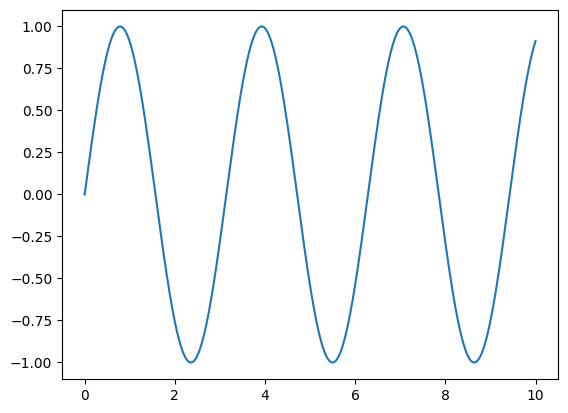

In [7]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [8]:
size = 10
index = 0
value = 23

x = np.arange(size)
print(x)
x[index] = value
print(x)

#In JAX we delete immutable arrays, so we need to create a new array
x = jnp.arange(size)
print(x)
x[index] = value

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]
[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

If the input value x of x.at[idx].set(y) is not reused, you can tell JAX to optimize the array update to occur in-place.

In [ ]:
jax_array = jnp.zeros((3, 3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print('Original array unchanged:', jax_array)
print('Updated array:', updated_array)

print('New array post addition')
new_jax_array = jax_array.at[::2, :1].add(7.0)
print(new_jax_array)

Original array unchanged: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Updated array: [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
New array post addition
[[7. 0. 0.]
 [0. 0. 0.]
 [7. 0. 0.]]


JAX handles random numbers differently (for the same reason as above)

In [ ]:
seed = 0
key = jax.random.PRNGKey(seed)

x = jax.random.normal(key, (10,)) #You need to explicitly pass the key i.e. PRNGKey
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [ ]:
#JAX is AI accelerator agnostic. Same code runs everywhere!
size = 3000

#Data is automatically pushed to AI accelerator (GPU/TPU)
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

print('[1] GPU')
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
print('[2] Pure numpy (CPU)')
%timeit np.dot(x_np, x_np.T)
print('[3] GPU + data transfer')
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = jax.device_put(x_np) #Push numpy explicitly to GPU
print('[4] GPU + explicit pre-data transfer (like [1] but explicit)')
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

[1] GPU
109 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[2] Pure numpy (CPU)
26.9 ms ± 731 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[3] GPU + data transfer
110 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[4] GPU + explicit pre-data transfer (like [1] but explicit)
113 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<h1>JAX Transofrmation functions</h1>
$jit$ compiles your functions using XLA and caches them to reach the best speed

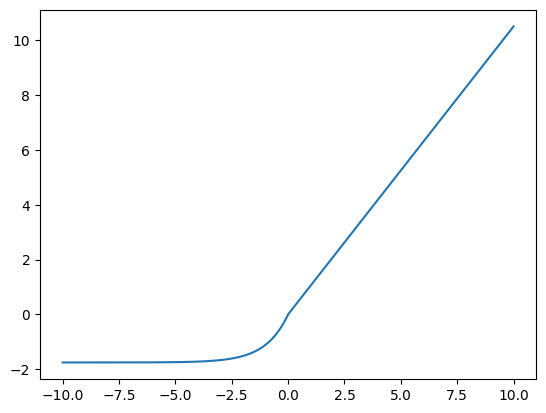

Non-jit
1.11 ms ± 23.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Jit
299 μs ± 5.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y=fn(x)
    plt.plot(x, y)
    plt.show()

def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jax.jit(selu) #Let's jit it

visualize_fn(selu) #Visualize selu

data = jax.random.normal(key, (1000000,)) #Benchmark non-jit vs jit version

print('Non-jit')
%timeit selu(data).block_until_ready()
print('Jit')
%timeit selu_jit(data).block_until_ready()

<h1>Automatic differentiation in JAX</h1>
JAX augments numpy and python code with function transformations which make it trivial to perform operations common in machine learning programs. The function df = jax.grad(f, argnums = 0) takes the callable object f and returns another callable object, df, evaluating the gradient of f w.r.t. the argument(s) of index(es) argnums.

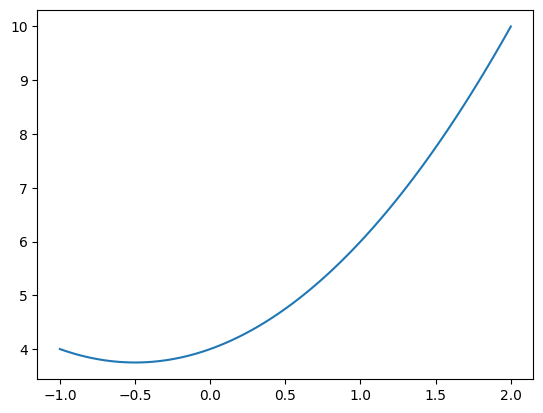

f at x=1.0: 6.0
df/dx at x=1.0: 3.0
d2f/dx2 at x=1.0: 2.0
d3f/dx3 at x=1.0: 0.0


In [ ]:
x = 1.0

f = lambda x: x**2 + x + 4
visualize_fn(f, l=-1, r=2, n=100)

dfdx = jax.grad(f) #2x + 1
d2fdx = jax.grad(dfdx) #2
d3fdx = jax.grad(d2fdx) #0

print(f'f at x={x}:', f(x))
print(f'df/dx at x={x}:', dfdx(x))
print(f'd2f/dx2 at x={x}:', d2fdx(x))
print(f'd3f/dx3 at x={x}:', d3fdx(x))

<h3>What if we had two inputs?</h3>
We use jacrev and jacfwd:<br>
These two functions compute the same values (up to machine numerics), but differ in their implementation: jacfwd user forward-mode automatic differentiation, which is more efficient for "tall" Jacobian matrices, while jacre uses reverse-mode, which is more efficient for
"wide" Jacobian matrices. For matrices that are near-square, jacfwd probably has an edge over jacrev.
To implement hessian, we could have used jacfwd (jacrev(f)) or jacrev(jacfwd(f)) or any other composition of the two. But forward-over-reverse is typically the most efficient. That's because in the inner Jacobian computation we're often differentiating a function wide Jacobian (maybe like a loss function f: R" → R), while in the outer Jacobian computation we're differentiating a function with a square Jacobian (since Vf: R" → R"), which is where forward-mode wins out.

In [ ]:
f = lambda x, y: x**2 + y**2

def eval_hessian(f):
    return jax.jit(jax.jacfwd(jax.jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

jacobian = jax.jacrev(f, argnums=(0, 1))(1.0, 1.0)
hessian = eval_hessian(f)(1.0, 1.0)
print('Jacobian:', jacobian)
print('Hessian:', hessian)

Jacobian: (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Hessian: ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


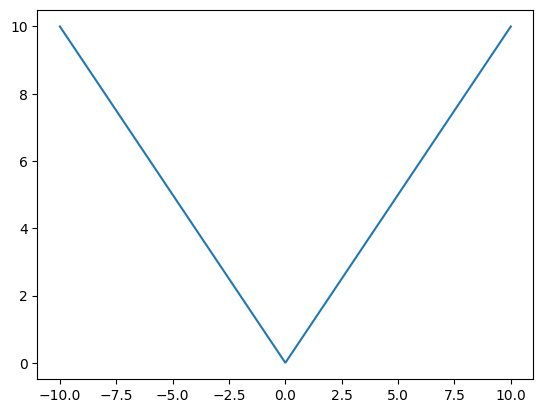

dfdx(0.0) = 1.00000000000000000e+00
dfdx(+1e-5) = 1.00000000000000000e+00
dfdx(-1e-5) = -1.00000000000000000e+00


In [ ]:
#Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

dfdx = jax.grad(f)
print(f"dfdx(0.0) = {dfdx(0.0):.17e}")
print(f"dfdx(+1e-5) = {dfdx(+1e-5):.17e}")
print(f"dfdx(-1e-5) = {dfdx(-1e-5):.17e}")

<h1>Vectorize functions using vmap()</h1>

In [ ]:
def custom_dot(x, y):
    return jnp.dot(x, y)**2

def native_custom_dot(x_batched, y_batched):
    return jnp.stack([
        custom_dot(v1, v2)
        for v1, v2 in zip(x_batched, y_batched)
    ])

@jax.jit
def jit_native_custom_dot(x_batched, y_batched):
    return jnp.stack([
        custom_dot(v1, v2)
        for v1, v2 in zip(x_batched, y_batched)
    ])

batched_custom_dot = jax.vmap(custom_dot, in_axes=[0, 0])
jit_batched_custom_dot = jax.jit(jax.vmap(custom_dot, in_axes=[0, 0]))

x = jnp.asarray(np.random.rand(1000, 50))
y = jnp.asarray(np.random.rand(1000, 50))

print("Naive")
%timeit native_custom_dot(x, y)
print("Vectorized")
%timeit batched_custom_dot(x, y)
print("JIT")
%timeit jit_native_custom_dot(x, y)
print("Vectorized + JIT")
%timeit jit_batched_custom_dot(x, y)

Naive
43.8 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vectorized
196 μs ± 6.85 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
JIT
The slowest run took 9.22 times longer than the fastest. This could mean that an intermediate result is being cached.
8.78 μs ± 9.52 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vectorized + JIT
28.8 μs ± 552 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<h3>The nitty-gritty: JAX API structure</h3>

In [ ]:
#lax is stricter
print(jnp.add(1, 1.0)) #jax.numpy API implicitly promotes mixed types
print(lax.add(1.0, 1.0)) #works
print(lax.add(1, 1.0)) #lax API is stricter

2.0
2.0


ValueError: Cannot lower jaxpr with verifier errors:
	op requires the same element type for all operands and results
		at loc("jit(add)/jit(main)/add"(callsite("<module>"("/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/3826632704.py":4:6) at callsite("_run_code"("<frozen runpy>":88:4) at "_run_module_as_main"("<frozen runpy>":198:11)))))
Define JAX_DUMP_IR_TO to dump the module.

In [ ]:
#lax is more powerful (but as a tradeoff less user-friendly)
x = jnp.array([1, 2, 1])
y = jnp.ones(10)

#numpy API
result1 = jnp.convolve(x, y)

#lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)]
)

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1e-6)

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


<h3>The limitations of JIT</h3>
We have used boolean mask extensively, what happens if we use them in JAX?

In [ ]:
def get_negatives(x):
    return x[x < 0]

x = jax.random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))
print(jax.jit(get_negatives)(x))

NameError: name 'key' is not defined

In [ ]:
#So how does it works in the background? -> tracing on different levels of abstraction

@jax.jit
def f(x, y):
    print("Running f():")
    print(f" x = {x}")
    print(f" y = {y}")
    result = jnp.dot(x+1, y+1)
    print(f" result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y)) #The first call has the overhead of compiling the function

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second call:")
print(f(x2, y2)) #Oops! Side effects (like print) are not compiled

Running f():
 x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
 y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
 result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[3.4058776 1.1025605 6.2818747]
Second call:
[ 4.287442   2.8473392 10.440915 ]


In [ ]:
#Same function as above just without the print statements
def f(x,y):
    return jnp.dot(x+1, y+1)

print(jax.make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [ ]:
#2nd example of failure
@jax.jit
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/1423787491.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
#Workaround: the "static" arguments
from functools import partial

def f1(x):
    return -x

def f2(x):
    return x

@partial(jax.jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(1, False))
#Here we do another jit compilation
print(f(2, False))
print(f(23, False))
#Here we do another jit compilation
print(f(44, 1))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
1
2
23
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-44


JAX is designed to work only on pure functions!<br>
Pure functions? Informal definition:<br>
-All the input data is passed through the function parameters, all the results are output through the function results.<br>
-A pure function will always return the same result if invoked with the same inputs.

In [ ]:
g = 0.0

def impure_uses_globals(x):
    return x + g #Violating both #1 and #2

#JAX captures the value of the global during the first run
print("First call: ", jax.jit(impure_uses_globals)(4.0))

#Let's update the global
g = 10.0

#Subsequent runs may silently use the cached value of the globals
print("Second call: ", jax.jit(impure_uses_globals)(5.0))

#JAX re-runs the python function when the type or shape of the argument changes
#This will end up reading the latest value of the global
print("Third call, different type: ", jax.jit(impure_uses_globals)(jnp.array([4.0])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


<h3>Out-of-bounds indexing</h3>
Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp airthmetic results in NaNs and not an exception).

In [ ]:
#JAX behavior
#1) Updates at out-of-bounds indices are skipped
#2) Retrievals reuslt in index being clamped
#In general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23)) #Example of 1)
print(jnp.arange(10)[11]) #Example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


<h3>Random numbers</h3>

In [ ]:
#numpy - PRNG is stateful!
seed = 0

#Let's sample calling the same function twice
np.random.seed(seed)

rng_state = np.random.get_state()
print("numpy random state:", rng_state[2:])

print("A random number:", np.random.random())
rng_state = np.random.get_state()
print("numpy random state: ", rng_state[2:])

print("A random number:", np.random.random())
rng_state = np.random.get_state()
print("numpy random state: ", rng_state[2:])

numpy random state: (624, 0, 0.0)
A random number: 0.5488135039273248
numpy random state:  (2, 0, 0.0)
A random number: 0.7151893663724195
numpy random state:  (4, 0, 0.0)


In [ ]:
#Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = jax.random.split(key, 10)
normal_pseudorandom = jax.random.normal(subkey, shape=(1,))
print("      \---SPLIT---> new key", key)
print("               \-->new subkey", subkey, "---> normal", normal_pseudorandom)

<>:6: SyntaxWarning: invalid escape sequence '\-'
<>:7: SyntaxWarning: invalid escape sequence '\-'
<>:6: SyntaxWarning: invalid escape sequence '\-'
<>:7: SyntaxWarning: invalid escape sequence '\-'
/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/964912892.py:6: SyntaxWarning: invalid escape sequence '\-'
  print("      \---SPLIT---> new key", key)
/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/964912892.py:7: SyntaxWarning: invalid escape sequence '\-'
  print("               \-->new subkey", subkey, "---> normal", normal_pseudorandom)
/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/964912892.py:6: SyntaxWarning: invalid escape sequence '\-'
  print("      \---SPLIT---> new key", key)
/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_2019/964912892.py:7: SyntaxWarning: invalid escape sequence '\-'
  print("               \-->new subkey", subkey, "---> normal", normal_pseudorandom)


NameError: name 'key' is not defined

In [ ]:
np.random.seed(seed)

def bar():
    return np.random.uniform()

def baz():
    return np.random.uniform()

# e.g. imagine bar and baz run on two different CPU/GPU (in a parallel env)
# than the result may be either [0.3 + 2*0.4] or [0.4 + 2*0.3]
# depending on how first calls the 'np.random.uniform' between 'bar' and 'baz'

def foo():
    return bar() + 2 * baz()

print(foo())

NameError: name 'seed' is not defined

<h2>Support Vector Regression (SVR) Hands-on Excercise</h2>
In this excercise, we will implement a train a SVR model using JAX and evaluate its performance on synthetic data. We will go through the steps of data generation, model training and evaluation.<br>
<h3>Objectives</h3>
-Generate synthetic data for regression<br>
-Implement SVR using JAXX<br>
-Train the SVR model<br>
-Evaluate the model's performance<br>
-Visualize the results<br>
<h2>Step 1: Import the libraries</h2>
We will begin by importing the necessary libraries. JAX will be used for numerical computations, numpy for array manipulations, and matplotlib for visualization.

In [9]:
import jax
import jax.numpy as jnp
import jax.scipy.optimize

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<h2>Step 2: Define the SVR class</h2>
We will create a class SVR to encapsulate the SVR model. The class will include methods for calculating the loss, training the model, and making predictions.<br>
<h3>Loss function</h3>
This loss function for SVR is defined as:

$$
L = \lambda||w||^2 + \frac{1}{n}\sum_{i=1}^{n} \max(0, |f(x_i)-y_i| - \epsilon)
$$

where:<br>
-$w$ are the model parameters<br>
-$\lambda$ is the regularization parameter<br>
-$\epsilon$ is the epsilon-intensive loss threshold<br>
-$f(x_i)$ is the predicted value for input $x_i$<br>
-$y_i$ is the actual target value<br><br>
Let's define the SVR class.

In [10]:
class SVR:
    def __init__(self, epsilon=0.1, lmbda=1.0, learning_rate=0.01, max_iters=1000):
        self.epsilon = epsilon
        self.lmbda = lmbda
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.w = None
    
    def loss(self, params, X, y):
        #1. Compute the y predictions
        predictions = jnp.dot(X, self.w[:-1]) + self.w[-1]
        #2. Compute epsilon-intensive loss
        eps_loss = jnp.maximum(0, jnp.abs(predictions - y) - self.epsilon)
        #3. Regularization term (L2 norm of w)
        reg = self.lmbda * jnp.sum(self-w**2)
        #4. Total loss
        return jnp.mean(eps_loss) + reg

    def train(self, X, y):
        #Initalize weights and bias self.w
        self.w = jnp.zeros(X.shape[1] + 1)

        #Solve the optimization problem
        opt_res = jax.scipy.optimize.minimize(
            self.loss, self.w, method="BFGS", args=(X, y),
        )
        self.w = opt_res.x

    def predict(self, X):
        return jnp.dot(X, self.w[:-1]) + self.w[-1]

<h2>Step 3: Generate synthetic data</h2>
Next, we will generate synthetic data for regression. We will create a linear relationship with added Gaussian noise.<br>
-We will generate n_samples data points.<br>
-The true relationship will follow the equation y = mx + c.<br>
-Gaussian noise will be added to simulate real-world data.<br>

In [11]:
np.random.seed(0)
m = 2.5
c = 1.0
n_samples = 100

#Generate X values uniformly distributed between 0 and 10
X = np.random.uniform(0, 10, size=(n_samples, 1))

#Create the line (y = mx + c) and add Gaussian noise
noise = np.random.randn(n_samples, 1)
y = m * X + c + noise
y = y.flatten()

<h2>Step 4: Split the data</h2>
Now, we will split the dataset into training and testing sets. This allows us to evaluate the model's performance on unseen data.<br>
We will use an 80-20 split for training and testing.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Convert data to JAX arrays
X_train = jnp.asarray(X_train)
y_train = jnp.asarray(y_train)
X_test = jnp.asarray(X_test)
y_test = jnp.asarray(y_test)

<h2>Step 5: Train the SVR model</h2>
We will now create an instance of the SVR class and train the model using the training data.

In [ ]:
svr = SVR(epsilon=1.0, lmbda=0.1)
svr.train(X_train, y_train)

<h2>Step 6: Make Predictions</h2>
After training, we will use the model to make predictions on both training and testing datasets.

In [ ]:
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

<h2>Step 7: Evaluate the model</h2>
We will evaluate the model's performance using the Mean Square Error (MSE), which is defined as:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2
$$

where:<br>
-$y_i$ is the actual value<br>
-$\hat{y_i}$ is the predicted value<br>
-n is the number of samples<br>

In [ ]:
mse_train = jnp.mean((y_train - y_pred_train)**2)
mse_test = jnp.mean((y_test - y_pred_test)**2)
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

<h2>Step 8: Visualize the results</h2>
Finally, we will visualize the training data, test data, and the model's prediction. This will help us understand how well our model has captured the underlying relationship.

In [ ]:
plt.figure(figsize=(10, 6))

#Plot training data
plt.scatter(X_train, y_train, label="Training data")
#Plot test data
plt.scatter(X_test, y_test, label="Test data")

#Plot the prediction line (SVR model)
x_range = jnp.linspace(0, 10, 1000).reshape((-1, 1))
y_pred_line = svr.predict(x_range)
plt.plot(x_range, y_pred_line, label="SVR prediction", color="red")
plt.plot(x_range, y_pred_line - svr.epsilon, linestyle="--", color="red", label="SVR epsilon")
plt.plot(x_range, y_pred_line + svr.epsilon, linestyle="--", color="red")

<h1>Support Vector Machine (SVM)</h1>
We will change the previous code to implement a linear Support Vector Machine in primal formulation.
<h2>Step 2: Define the SVM class</h2>
We will create a class SVM to encapsulate the SVM model. The class will include methods for calculating the loss, training the model, and making predictions.<br>
<h3>Loss function</h3>
The loss function for SVM is defined as the hinge loss:

$$
L(w) = \lambda||w||^2 + \frac{1}{n}\sum_{i=1}^{n} \max(0, 1 - y_i (w^Tx_i + b))
$$

where:<br>
-w are the model parameters (weights)<br>
-b is the bias term<br>
-$\lambda$ is the regularization parameter<br>
-$y_i$ is the true label for the sample i<br>
-$x_i$ is the feature vector for the sample i<br>
-The first term is the regularization term, and the second term is the hinge loss.<br><br>
Let's define the SVM class.

In [16]:
class SVM:
    def __init__(self, lmbda=1.0, learning_rate=0.01, max_iters=1000):
        self.lmbda = lmbda
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.w = None

    def loss(self, params, X, y):
        predictions = jnp.dot(X, params[:-1]) + params[-1]
        eps_loss = jnp.maximum(0, jnp.abs(predictions - y) - self.epsilon)
        reg = self.lmbda * jnp.sum(params**2)
        return jnp.mean(eps_loss) + reg

    def train(self, X, y):
        self.w = jnp.zeros(X.shape[1] + 1)
        opt_res = jax.scipy.optimize.minimize(
            self.loss, self.w, method="BFGS", args=(X, y),
        )
        self.w = opt_res.x

    def predict(self, X):
        decision = jnp.dot(X, self.w[:-1]) + self.w[-1]
        return jnp.sign(decision)

<h2>Step 3: Generate synthetic classification data</h2>
Next, we will generate synthetic data for classification. We will create a dataset of points in a 2D space and label them based on their coordinates.<br>
-We will generate $n_{samples}$ data points.<br>
-The labels will be determined by the condition $x_1 + x_2 > 10$ to classify the points into two categories.<br>

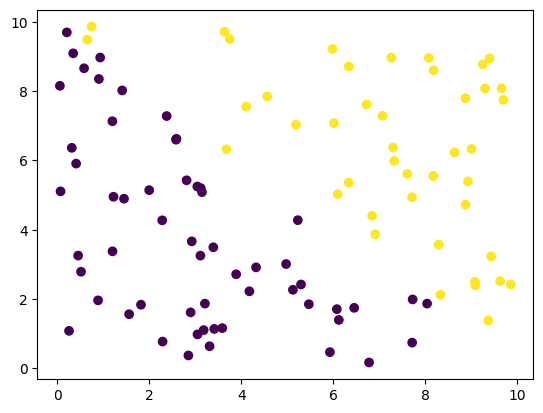

In [17]:
np.random.seed(42)
n_samples = 100

X = np.random.uniform(0, 10, size=(n_samples, 2))
y = np.where(X.sum(axis=1) > 10, 1, -1)
y = y.flatten()

plt.scatter(X[:, 0], X[:, 1], c=y)

<h2>Step 4: Split the data</h2>
Now, we will split the dataset into training and testing sets. This allows us to evaluate the model's performance on unseen data.<br>
We will use an 80-20 split for training and testing.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = jnp.asarray(X_train)
y_train = jnp.asarray(y_train)
X_test = jnp.asarray(X_test)
y_test = jnp.asarray(y_test)

<h2>Step 5: Train the SVM model</h2>
We will now create an instance of the SVM class and train the model using the training data.

In [ ]:
svm = SVM(lmbda=0.001)
svm.train(X_train, y_train)

<h2>Step 6: Make Predictions</h2>
After training, we will use the model to make predictions on both the training and testing datasets.

In [ ]:
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

<h2>Step 7: Evaluate the model</h2>
We will evaluate model's performance using accuracy, which is defined as the propotion of correct predictions.

$$
Accuracy = \frac{Number of correct predictions}{Total number of predictions}
$$

Let's calculate and print the accuracy for both the training and test stes.

In [ ]:
accuracy_train = jnp.sum(y_pred_train == y_train) / y_train.size
accuracy_test = jnp.sum(y_pred_test == y_test) / y_test.size
print(f"Train accuracy: {accuracy_train:.4f}")
print(f"Test accuracy: {accuracy_test:.4f}")

<h2>Step 8: Visualize the results</h2>
Finally, we will visualize the training data, test data, and the decision boundary of the SVM model. This will help us understand how well our model has separated the classes.

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.scatter(X_test[:, 0], X_test[:, 1], marker="x")

xx1, xx2 = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
xx = np.stack([xx1.flatten(), xx2.flatten()], axis=1)
yy = svm.predict(xx)
plt.contoutf(xx1, xx2, yy.reshape(xx1.shape), alpha=0.1)